# Introduction à l'apprentissage par renforcement
# TP 1 - le bandit-manchot multi-bras

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

# Définition des vaccins

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class ArmBernoulli:
    def __init__(self, p: float, random_state: int = 0):
        """
        Bernoulli arm
        Args:
             p (float): mean parameter
             random_state (int): seed to make experiments reproducible
        """
        self.mean = p
        self.local_random = np.random.RandomState(random_state)
        
    def sample(self, printable = False):
        random = self.local_random.rand()
        
        if printable:
            print (f"random: {random}, mean: {self.mean}")
        return random < self.mean

    
K = 5
T = 100
np.random.seed(1)
means = np.random.random(K)
MAB = [ArmBernoulli(m) for m in means]
assert(MAB[0].mean == means[0])

In [51]:
means

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
       1.46755891e-01])

In [52]:
list(map(lambda arm: arm.mean, MAB))

[0.417022004702574,
 0.7203244934421581,
 0.00011437481734488664,
 0.30233257263183977,
 0.14675589081711304]

In [53]:
MAB[0].sample(printable=True)

random: 0.8773987891741196, mean: 0.417022004702574


False

**Vaccins :** ils sont notés $A_k\leq K$, leur probabilité d'immunisation est $p_k = \mu_k$.

**Récompense :** 1 si le patient $t$ est immunisé et 0 sinon.

**Action optimale :** choisir le vaccin $a$ avec la meilleure probabilité $a^* = \arg\max_{a\leq K} \mu_{a}$.

**Regret :** $R_T =T\mu_a^* - \mathbb{E} \left[ \sum_{t=1}^T r_t \right]$
En notant $N_a(t)$, le nombre de fois que le vaccin $a$ a été choisi jusqu'à $t$ et $\Delta_a = \mu_a^* - \mu_a$, le regret s'exprime :

$$R_T = \sum_{a=1}^K \Delta_a \mathbb{E} \left[ N_{a_T} \right]$$


**Expliquez ce que signifie le regret concrètement. Pourquoi minimiser le regret donne une bonne solution au problème du bandit-manchot** <br><br>
Le regret signifie l'accumulation de la différence entre la récompense maximale et la récompense obtenue.<br>
Plus on avance en exploration avec une stratégie qui n'est pas la stratégie optimale plus le regret augmente.<br>
Ainsi minimiser le regret permet de maximiser la récompense obtenue car il permet de s'orienter vers la stratégie optimale.

# Solution naive

 La solution naive consiste en 2 étapes distinctes :

1. Entraînement : on teste les K vaccins sur N patients et on note leur efficacité séparemment
2. Exploitation : le vaccin qui apparaît comme le meilleur est choisi pour les T-N patients restants.

**Implémentez cet algorithme avec T=100, N=20, K=5. Quel bras a été choisi lors de la seconde phase ?**

In [80]:
N = 20
nb_groupe = K # here 5 
groupe_size = int(N / nb_groupe) # here 4
rewards = np.zeros((nb_groupe, groupe_size)) 


In [84]:
def compute_rewards(rewards, nb_groupe):
    for groupe in range(nb_groupe):
        rewards[groupe] = [MAB[groupe].sample() for i in range(groupe_size)]
    return rewards

rewards = compute_rewards(rewards, nb_groupe)
rewards

array([[1., 0., 0., 0.],
       [1., 1., 1., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [85]:
list_vaccin = rewards.flatten()
list_vaccin

array([1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0.])

On estime quel vaccin produit la meilleure immunisation sur les n premiers patients :

$R_𝑖 = (1/T_𝑖) \sum_{k=0}^{n−1} X_(v_k,i) R_𝑘$

On choisit le vaccin avec le meilleur (𝑅_𝑖 ) pour tous les patients suivants.


In [86]:
r_i = rewards.mean(axis=1)
print(f"{r_i = }")

best_groupe = np.argmax(r_i)
print(f"{best_groupe = }")

r_i = array([0.25, 0.75, 0.  , 0.25, 0.25])
best_groupe = 1


**Obtenez-vous toujours le même résultat ? Testez l'algorithme avec une valeur de N plus faible. Qu'en concluez-vous ?** <br><br>
Le résultat obtenu est aléatoire car on ne teste pas tous les vaccins sur tous les patients. <br>
Plus N est faible plus le résultat est incertain du à la loi des grands nombres. <br>
On peut conclure que le choix du vaccin après la phase d'entreinement n'est peut être pas le meilleur dépendemmment de la valeur de N. <br>

**Tracez l'évolution du regret $r_t$ de votre algorithme en fonction du résultat obtenu avec le patient $t<T$ sur plusieurs expériences. Représentez l'évolution moyenne de ce regret sur plusieurs expériences.**

In [87]:
def Regret_i(N, mu, list_vaccine):
    """
        N : number of patients tested
        mu : mean reward of the best vaccin
        list_vaccine : list of rewards for each patient
    """
    E = np.sum(list_vaccine) 
    return N * mu - E

In [88]:
mu_opti = np.max(means)
mu_opti

0.7203244934421581

In [89]:
def compute_regret(l, vaccin):
    list_vaccin = list(l.copy())
    r = []

    ## Entrainement
    for i in range(1, N):
        r.append(Regret_i(i, mu_opti, list_vaccin[:i]))

    ## Exploration
    for i in range(T-N):
        list_vaccin.append(MAB[vaccin].sample())
        r.append(Regret_i(len(list_vaccin), mu_opti, list_vaccin[:N+i+1]))
    return r


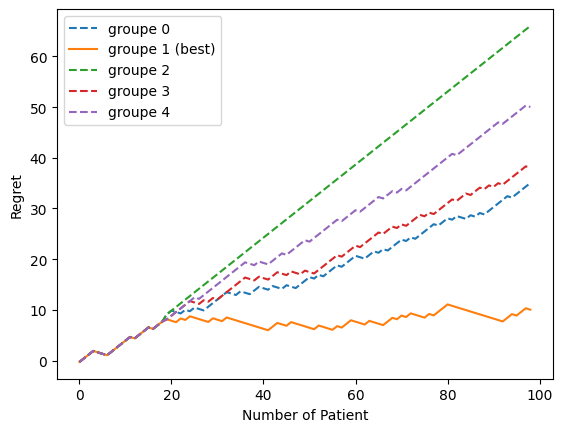

In [90]:

regrets = []
for i in range(K):
    regrets.append(compute_regret(list_vaccin, i))
    if i == best_groupe:
        plt.plot(regrets[i], label=f"groupe {i} (best)")
    else:
        plt.plot(regrets[i],  '--', label=f"groupe {i}",)
plt.xlabel("Number of Patient")
plt.ylabel("Regret")    
plt.legend()


## Upper Confidence Bounds (P. Auer, 2002)

L'action $a_t$ l'instant $t$ est donnée par : 

$$a_t = max_a \left[ X_t(a) + B_t(a) \right]$$

où $X_t(a)$ est la moyenne empirique de la récompense obtenue avec le vaccin $a$ et $B_t(a)$ est un biais :

$B_t(a) = \sqrt{ \frac{2\log t}{T_a}}$ où $T_a$ est le nombre de fois que le vaccin $a$ a été choisi.

**Pourquoi cet algorithme n'a pas besoin d'une phase d'entraînement ? Quel terme favorise l'exploration et quel terme favorise l'exploitation ?** <bR><br>
Upper Confidence Bounds n'a pas besoin d'une phase d'entrainement car il estime la récompense de chaque vaccin à chaque instant t. <br>
Le terme $X_t(a)$ favorise l'exploitation car il estime la récompense moyenne du vaccin choisi. <br>
Le terme $B_t(a)$ favorise l'exploration, il mesure l'incertitude sur la récompense moyenne de chaque vaccin.<br>
Plus $T_a$ est grand plus $B_t(a)$ est petit et plus on exploite le vaccin a avec certitude. <br>

**Implémentez l'algorithme et tracez l'évolution du regret à partir de cet algorithme.**

In [101]:
def R_i_2(N, T, mu, list_vaccine, k=1):
    """
        N : number of patients tested
        T : number of times vaccin is tested
        mu : mean reward of the best vaccin
        list_vaccine : list of rewards for each patient
        k : constant control of biais
    """
    E = np.sum(list_vaccine)
    biais = np.sqrt(2 * np.log(N) / T)
    return N * mu - E + k * biais


In [109]:

def upper_bound(T, mu_opti, K):
    list_patient = [[]] * K
    list_a = [10] * K
    list_regret = []
    list_choice = []
    
    for i in range(1, T):
        a = np.argmax(list_a)
        
        list_patient[a].append(MAB[a].sample())
        
        N = i
        T_i = len(list_patient[a])
        regret = R_i_2(N, T_i, mu_opti, list_patient[a])
        
        list_a[a] = regret
        list_regret.append(regret)
        list_choice.append(a)
        print(list_a)

    return list_regret, list_choice


In [110]:
list_regret, list_choice = upper_bound(T, mu_opti, K)

[-0.2796755065578419, 10, 10, 10, 10]
[-0.2796755065578419, 1.2732035980420138, 10, 10, 10]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143, 10, 10]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143, 2.71385258492633, 10]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143, 2.71385258492633, 3.403978476083186]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143, 2.71385258492633, 4.0947685160002045]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143, 2.71385258492633, 4.787908314974127]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143, 2.71385258492633, 5.483609390837707]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143, 2.71385258492633, 6.181685156958226]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143, 2.71385258492633, 6.881858976863092]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143, 2.71385258492633, 7.583857969859292]
[-0.2796755065578419, 1.2732035980420138, 2.0167819825309143

(array([ 1.,  1.,  1.,  1., 95.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

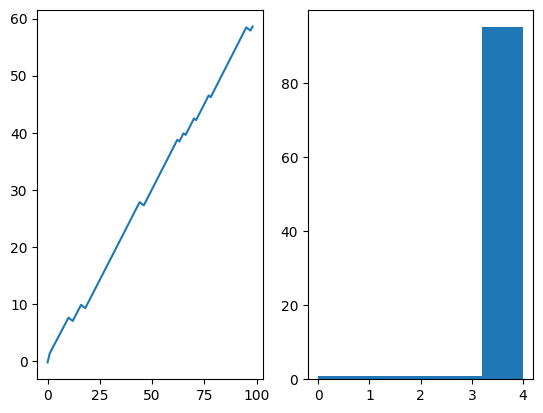

In [111]:
plt.subplot(1, 2, 1)
plt.plot(list_regret)
plt.subplot(1, 2, 2)
plt.hist(list_choice, bins=K)

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des valeurs de $(X_a)_a$ et de $(B_a)_a$ au cours du temps**

Ici, c'est à vous de réfléchir à la meilleure représentation de ces valeurs.

# Echantillonnage de Thomson

L'algorithme de Thompson calcule à chaque instant $t$ le paramètre des lois Beta pour tous les vaccins. Il échantillonne alors une probabilité de choisir chaque vaccin et choisit le vaccin avec la plus grande probabilité.

**Comment fonctionnent les lois Beta ? Comment les mettre à jour selon les résultats des vaccins ?**

**Comment se passent l'exploration et l'exploitation ?**

**Implémentez l'algorithme et tracez l'évolution du regret.**

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des probabilités au cours du temps**

Indice : pour représenter des probabilités, on pourra utiliser des diagrammes en violons.